
 
**Dataset:** Indoor Scene Recognition

**Fontes:**

* http://web.mit.edu/torralba/www/indoor.html
* https://github.com/ashrutkumar/Indoor-scene-recognition

**Evaluation Set:** 
* https://web.mit.edu/torralba/www/TrainingImages.txt
* https://web.mit.edu/torralba/www/TestImages.txt

In [ ]:
import os
import pandas as pd

# Download Data

In [ ]:
# Training Set
!wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar

# Evaluating Set
#!wget https://web.mit.edu/torralba/www/TrainingImages.txt
#!wget https://web.mit.edu/torralba/www/TestImages.txt

--2022-06-18 12:14:32--  http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592010240 (2.4G) [application/x-tar]
Saving to: ‘indoorCVPR_09.tar’

indoorCVPR_09.tar   100%[===================>]   2.41G  13.1MB/s    in 2m 3s   

2022-06-18 12:16:35 (20.2 MB/s) - ‘indoorCVPR_09.tar’ saved [2592010240/2592010240]



In [ ]:
!tar -xvf ./indoorCVPR_09.tar

Streaming output truncated to the last 5000 lines.
Images/mall/cover_home3.jpg
Images/mall/CP67791.jpg
Images/mall/crocker_galleria_735089.jpg
Images/mall/mall1.jpg
Images/mall/d8.jpg
Images/mall/deira_city_centre_dubai_08.jpg
Images/mall/dungarv_new_mall.jpg
Images/mall/latham_circle_mall_16.jpg
Images/mall/eastridg1.jpg
Images/mall/IMG_6449.jpg
Images/mall/main_boutique_b.jpg
Images/mall/easyfranchise_centre_commercial_1.jpg
Images/mall/ins42.jpg
Images/mall/mall14.jpg
Images/mall/eaton_centre_2001_03.jpg
Images/mall/ins43.jpg
Images/mall/mall17.jpg
Images/mall/full_shopping_Central_1.jpg
Images/mall/galleria.jpg
Images/mall/galleria1.jpg
Images/mall/galleria2.jpg
Images/mall/Galleria_003.jpg
Images/mall/laurel_mall_06.jpg
Images/mall/Galleria_1.jpg
Images/mall/galleria_san_federico_nr_109_2_n1.jpg
Images/mall/ins23.jpg
Images/mall/ins44.jpg
Images/mall/mall18.jpg
Images/mall/galleria_vittorio_emanuele_ii_milan_mlgalar.jpg
Images/mall/ins45.jpg
Images/mall/mall19.jpg
Images/mall/GUM_

In [ ]:
## GROUPS CHECKING
groups = {
  "Store":["bakery", "grocerystore", "clothingstore", "deli", "laundromat", "jewelleryshop", "bookstore", "videostore", "florist", "shoeshop", "mall", "toystore"],
  "Home":["bedroom", "nursery", "closet", "pantry", "children_room", "lobby", "dining_room", "corridor", "livingroom", "bathroom", "kitchen"],
  "Public spaces":["prisoncell", "library", "cloister", "church_inside", "waitingroom", "museum", "elevator", "subway", "locker_room", "trainstation", "airport_inside"],
  "Leisure":["buffet", "fastfood_restaurant", "concert_hall", "restaurant", "bar", "movietheater", "gameroom", "casino", "bowling", "gym", "hairsalon"],
  "Working place":["hospitalroom", "kindergarden", "restaurant", "kitchen", "artstudio", "classroom", "laboratorywet", "studiomusic", "operating_room", "office", "computerroom", "warehouse", "greenhouse", "dentaloffice", "tv_studio", "meeting_room"]
 }

# for group in groups.keys():
#  for category in groups[group]:
#    if category in list(labeldict.keys()):
#      pass
#    else:
#      print(category)

In [ ]:
!rm -rf /Images

In [ ]:
files=[x.split("/")[-1]for x in [x[0] for x in os.walk("Images")][1:]]
files.sort()
labeldict={}
count=0

for file in files:
    labeldict[file]=count
    count+=1
    
from collections import defaultdict
class_freq=defaultdict(int)
csvlist=[]

for file in files:
    images=os.listdir(os.path.join(os.getcwd() + "/Images",file))
    count=1
    for img in images:
        an=img.split(".")        
        newname=str(file)+"_"+str(count)+"."+str(an[-1])
        os.rename(os.path.join(os.getcwd() + "/Images",file,img),os.path.join(os.getcwd() + "/Images",newname))
        csvlist.append([file, labeldict[file],newname])
        class_freq[file]+=1
        count+=1
        
for file in files:
    os.rmdir(os.path.join(os.getcwd() + "/Images",file))

df = pd.DataFrame(csvlist,columns=["Category", "Category_Id","File"]) 
df = df[df['Category'] == 'bedroom']
df.to_csv("Train.csv")
#!mv Train.csv ../Train.csv

In [ ]:
df["Weight"] = df["Category"].map(df["Category"].value_counts(normalize = True))

In [ ]:
df

,Category,Category_Id,File,Weight
2130,bedroom,6,bedroom_1.jpg,1.0
2131,bedroom,6,bedroom_2.jpg,1.0
2132,bedroom,6,bedroom_3.jpg,1.0
2133,bedroom,6,bedroom_4.jpg,1.0
2134,bedroom,6,bedroom_5.jpg,1.0
...,...,...,...,...
2787,bedroom,6,bedroom_658.jpg,1.0
2788,bedroom,6,bedroom_659.jpg,1.0
2789,bedroom,6,bedroom_660.jpg,1.0
2790,bedroom,6,bedroom_661.jpg,1.0


# Dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import glob
import random
import copy
import matplotlib.pyplot as plt
from math import floor
import uuid
%matplotlib inline 

In [ ]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset,SubsetRandomSampler,Sampler
from torch import nn
import torch.nn.functional as F
from torch import optim

In [ ]:
from skimage import io, transform
from PIL import Image
import PIL.ImageEnhance as ie
import PIL.Image as im
from torch.autograd import Variable

In [ ]:
#from google.colab import files,drive

In [ ]:
class ImageDataset(Dataset): 
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Id = File
        # Category = Category_Id
        img_name = os.path.join(self.root_dir, self.data_frame['File'][idx])         
        image = Image.open(img_name).convert('RGB')                               
        label = np.array(self.data_frame['Category_Id'][idx])                        
        if self.transform:            
            image = self.transform(image)                                         
        sample = (image, label) 
        return sample

In [ ]:
testando_transf = transforms.Compose([
        transforms.RandomResizedCrop(224)])

In [ ]:
# transform_augmented = transforms.Compose([
#         transforms.RandomResizedCrop(28),
#         #PowerPIL(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                      ])
# transform_raw = transforms.Compose([
#                      transforms.Resize((224,224)),
#                      transforms.ToTensor(),
#                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

transformation = transforms.Compose([
                     transforms.Resize(64),
                     transforms.CenterCrop(64),
                     transforms.ToTensor()])

In [ ]:
# trainset = ImageDataset(csv_file = 'Train.csv', root_dir = './Images', transform=transform_augmented)
# valset   = ImageDataset(csv_file = 'Train.csv', root_dir = './Images', transform=transform_raw)
# accset   = ImageDataset(csv_file = 'Train.csv', root_dir = './Images', transform=transform_raw)

In [ ]:
entendimento = ImageDataset(csv_file = 'Train.csv', root_dir = './Images', transform = transformation)

In [ ]:
trainloader = torch.utils.data.DataLoader(entendimento, batch_size=500, shuffle=True)

In [ ]:
%matplotlib inline


DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "../Images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs =1350

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

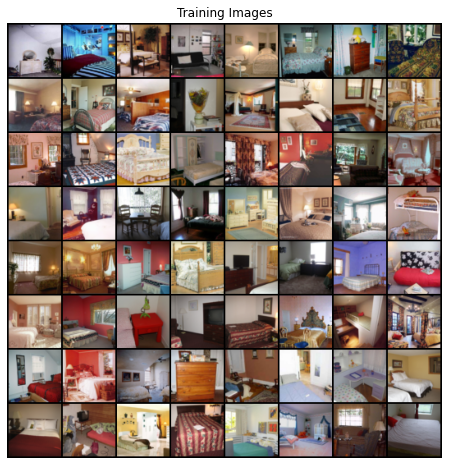

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageDataset(csv_file = 'Train.csv',
                       root_dir = './Images',
                       transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

count_parameters(netG)

# Print the model
print(netG)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| main.0.weight  |   819200   |
| main.1.weight  |    512     |
|  main.1.bias   |    512     |
| main.3.weight  |  2097152   |
| main.4.weight  |    256     |
|  main.4.bias   |    256     |
| main.6.weight  |   524288   |
| main.7.weight  |    128     |
|  main.7.bias   |    128     |
| main.9.weight  |   131072   |
| main.10.weight |     64     |
|  main.10.bias  |     64     |
| main.12.weight |    3072    |
+----------------+------------+
Total Trainable Params: 3576704
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Discriminator Code



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

count_parameters(netD)

# Print the model
print(netD)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| main.0.weight  |    3072    |
| main.2.weight  |   131072   |
| main.3.weight  |    128     |
|  main.3.bias   |    128     |
| main.5.weight  |   524288   |
| main.6.weight  |    256     |
|  main.6.bias   |    256     |
| main.8.weight  |  2097152   |
| main.9.weight  |    512     |
|  main.9.bias   |    512     |
| main.11.weight |    8192    |
+----------------+------------+
Total Trainable Params: 2765568
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

    # Plot the fake images from the last epoch
    if epoch % 10 == 0:
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,2)
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.show()

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




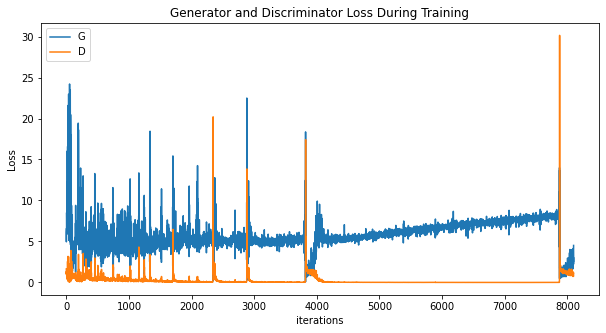

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




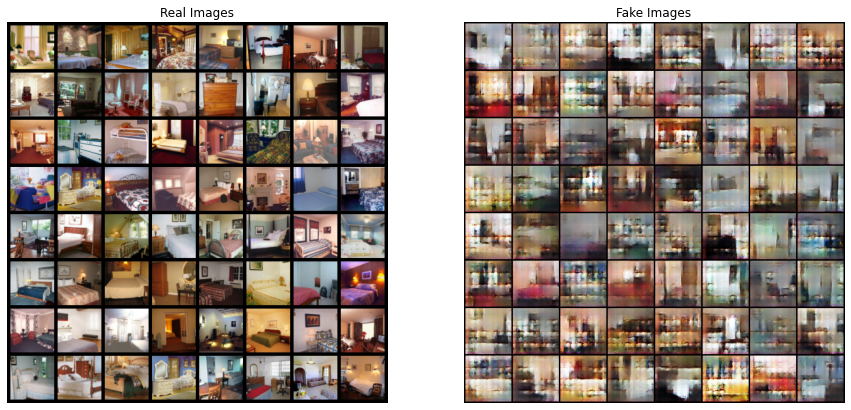

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()